# **TDP Week 3** - Electric Probes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sdas.tests.LoadSdasData import LoadSdasData
from sdas.tests.StartSdas import StartSdas

plt.style.use('bmh')

## **$1^{st}$ Part:**

Effect of the cut-off voltage on the estimated plasma parameters (particularly on the
electron temperature and fit quality)
for one I-V characteristic showing a deviation from
the exponential behaviour (data in table 1) [Note: I will consider 3 to 4 I-V characteristic curves.]

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35605|CHANNEL_030|CHANNEL_026|
|36892|CHANNEL_028|CHANNEL_029|
|36892|CHANNEL_026|CHANNEL_029|

**Table 1:** Data for the cut-off voltage analysis.

</center>

**Note:** The units of the signals are: Time ($\mu s$), Collected current (mA) and Applied voltage (V). 

In [2]:
# Load and select data
shot = 35605
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

In [3]:
def color_title(labels, colors, textprops ={'size':'large'}, ax = None, y = 1.033,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

In [4]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.savefig('1_V&I(t).svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets...
# Here, the 3 cycles are visible.

<Figure size 640x480 with 0 Axes>

In [5]:
# Selecting a time interval:
bool_indices = (time > 50500) & (time < 53900) # Considering 2 I-V curves, in the 2nd cycle.
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]
print(time_d[0], time_d[-1])

50500.5 53899.5


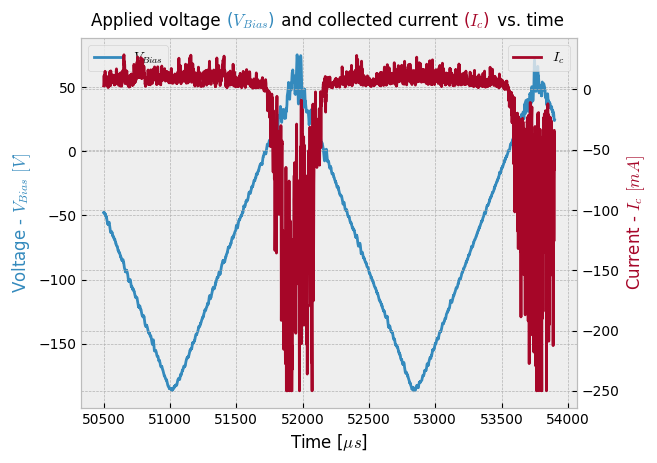

<Figure size 640x480 with 0 Axes>

In [6]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend()
ax2.legend()
plt.savefig('1_V&I(t)_2_Curves.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

In [7]:
from uncertainties import ufloat

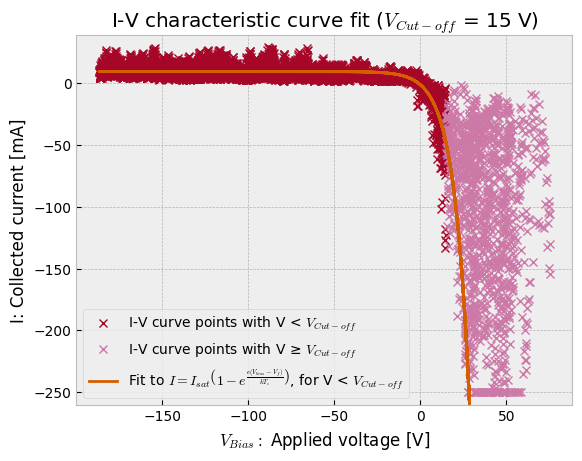

I_Sat = 9.23+/-0.07 [mA]
V_f = -1.23+/-0.31 [V]
T_e = (1.029+/-0.030)e+05 [K]
C_s = (4.12+/-0.06)e+04 [m/s]
n_e = (4.66+/-0.08)e+20 [m**(-3)]
V_p = 25.4+/-0.8 [V]
Reduce chi squared = 21.133923943472077. Should be ~1.


<Figure size 640x480 with 0 Axes>

In [8]:
from scipy.odr import *

# Defining constants:
e = 1.602177e-19     # Electron charge.    [This ('e' and 'k') leads to overflow (if introduced directly in fitting formula)!
k = 1.380649e-23     # Boltzmann constant.  Keep this in mind!]
m_i = 1.67262192e-27 # Ion mass (In our case of a hydrogen plasma, this is equal to the proton mass!)
A = 6e-6             # Probe area

# Fit data and plot
cut_off = 15
indices = (V_data_d < cut_off)
V_data_d_Cut = V_data_d[indices]
I_data_d_Cut = I_data_d[indices]

V_data_d_Not_Considered = V_data_d[~indices]
I_data_d_Not_Considered = I_data_d[~indices]

def func(B, V_Bias): # T_ef = T_e*(k/e)
    return B[0] * (1 - np.exp((V_Bias - B[1])/(B[2])))

# Fitting:
Fit_Model = Model(func)
My_Data = RealData(V_data_d_Cut, I_data_d_Cut)
odr = ODR(My_Data, Fit_Model, beta0=[10, -1, 2e5*(k/e)])
out = odr.run()

plt.plot(V_data_d_Cut, I_data_d_Cut, 'x',
label=r'I-V curve points with V < $V_{Cut-off}$',
color = 'C1')
plt.plot(V_data_d_Not_Considered, I_data_d_Not_Considered,'x',
label=r'I-V curve points with V ≥ $V_{Cut-off}$',
color = 'C5')
plt.plot(V_data_d, func(out.beta, V_data_d),
label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
color = 'C4')

plt.ylim([min(I_data_d) - 10, max(I_data_d) + 10])

plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
plt.ylabel(r'I: Collected current [mA]')
plt.grid(True)
plt.legend(loc = 'best')
plt.savefig('1_I(V)_Fit(V_Cutt-off = 15).svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

# Retrieving parameters and their standard deviations:
parameters = out.beta
perr = out.sd_beta

# I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
T_e_ufloat = ufloat(parameters[2], perr[2])
T_e_ufloat*=(e/k)

I_Sat_ufloat = ufloat(parameters[0], perr[0])
V_f_ufloat = ufloat(parameters[1], perr[1])

C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e

red_chi_sq = out.res_var

# Printing results
print(f'I_Sat = {I_Sat_ufloat} [mA]')
print(f'V_f = {V_f_ufloat} [V]')
print(f'T_e = {T_e_ufloat} [K]')

print(f'C_s = {C_s_ufloat} [m/s]')
print(f'n_e = {n_e_ufloat} [m**(-3)]')
print(f'V_p = {V_p_ufloat} [V]')

print(f'Reduce chi squared = {red_chi_sq}. Should be ~1.')

In [9]:
def Plasma_Params(V_cutoff):

    """
    Input: Cut-off voltage.
    Output: 1. 'all_parameters' vector:
        - all_parameters[0] -> I_Sat
        - all_parameters[1] -> V_f
        - all_parameters[2] -> T_e
        - all_parameters[3] -> C_s
        - all_parameters[4] -> n_e
        - all_parameters[5] -> V_p
            2. 'all_perr' vector:
        - all_perr[0] -> std_dev(I_Sat)
        - all_perr[1] -> std_dev(V_f)
        - all_perr[2] -> std_dev(T_e)
        - all_perr[3] -> std_dev(C_s)
        - all_perr[4] -> std_dev(n_e)
        - all_perr[5] -> std_dev(V_p)
    """

    indices = (V_data_d < V_cutoff)
    V_data_d_Cut = V_data_d[indices]
    I_data_d_Cut = I_data_d[indices]
    
    # Defining fitting function and fitting:
    def func(B, V_Bias): # T_ef = T_e*(k/e)
        return B[0] * (1 - np.exp((V_Bias - B[1])/(B[2])))
    # Fitting:
    Fit_Model = Model(func)
    My_Data = RealData(V_data_d_Cut, I_data_d_Cut)
    odr = ODR(My_Data, Fit_Model, beta0=[10, -1, 2e5*(k/e)])
    out = odr.run()
    
    # Retrieving parameters and their standard deviations:
    parameters = out.beta
    perr = out.sd_beta

    
    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    T_e_ufloat = ufloat(parameters[2], perr[2])
    T_e_ufloat*=(e/k)

    I_Sat_ufloat = ufloat(parameters[0], perr[0])
    V_f_ufloat = ufloat(parameters[1], perr[1])

    C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
    n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
    V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e

    red_chi_sq = out.res_var
    
    all_parameters = np.array([parameters[0], parameters[1], T_e_ufloat.n, C_s_ufloat.n, n_e_ufloat.n, V_p_ufloat.n])
    all_perrs = np.array([perr[0], perr[1], T_e_ufloat.s, C_s_ufloat.s, n_e_ufloat.s, V_p_ufloat.s])

    return(all_parameters, all_perrs/all_parameters*100, red_chi_sq) # Percentages!

In [10]:
# Defining cut-off voltages sweep:
V_Cutoff_Sweep = np.linspace(0, 70, 100) # Maybe try to change intial parameters guess (beta0)? # 1000 points.

y = []
yerr = []
red_chi = []

# Computing plasma parameters (and their uncertainties) for each value of the cut-off voltage (in the sweep):
for x in V_Cutoff_Sweep:
    y.append(Plasma_Params(x)[0])
    yerr.append(Plasma_Params(x)[1])
    red_chi.append(Plasma_Params(x)[2])

In [ ]:
# Values obtained for multiple cut-off voltages:
# Values:
I_Sat_list = [arr[0] for arr in y]
V_f_list   = [arr[1] for arr in y]
T_e_list   = [arr[2] for arr in y]
C_s_list   = [arr[3] for arr in y]
n_e_list   = [arr[4] for arr in y]
V_p_list   = [arr[5] for arr in y]

# Uncertainties:
I_Sat_err_list = [arr[0] for arr in yerr]
V_f_err_list   = [arr[1] for arr in yerr]
T_e_err_list   = [arr[2] for arr in yerr]
C_s_err_list   = [arr[3] for arr in yerr]
n_e_err_list   = [arr[4] for arr in yerr]
V_p_err_list   = [arr[5] for arr in yerr]

# Debugging:
# print(I_Sat_list)
# print(V_f_list)
# print(T_e_list)  
# print(C_s_list)  
# print(n_e_list)
# print(V_p_list)

# print(I_Sat_err_list)
# print(V_f_err_list)
# print(T_e_err_list)  
# print(C_s_err_list)  
# print(n_e_err_list)
# print(V_p_err_list)

# print(red_chi)

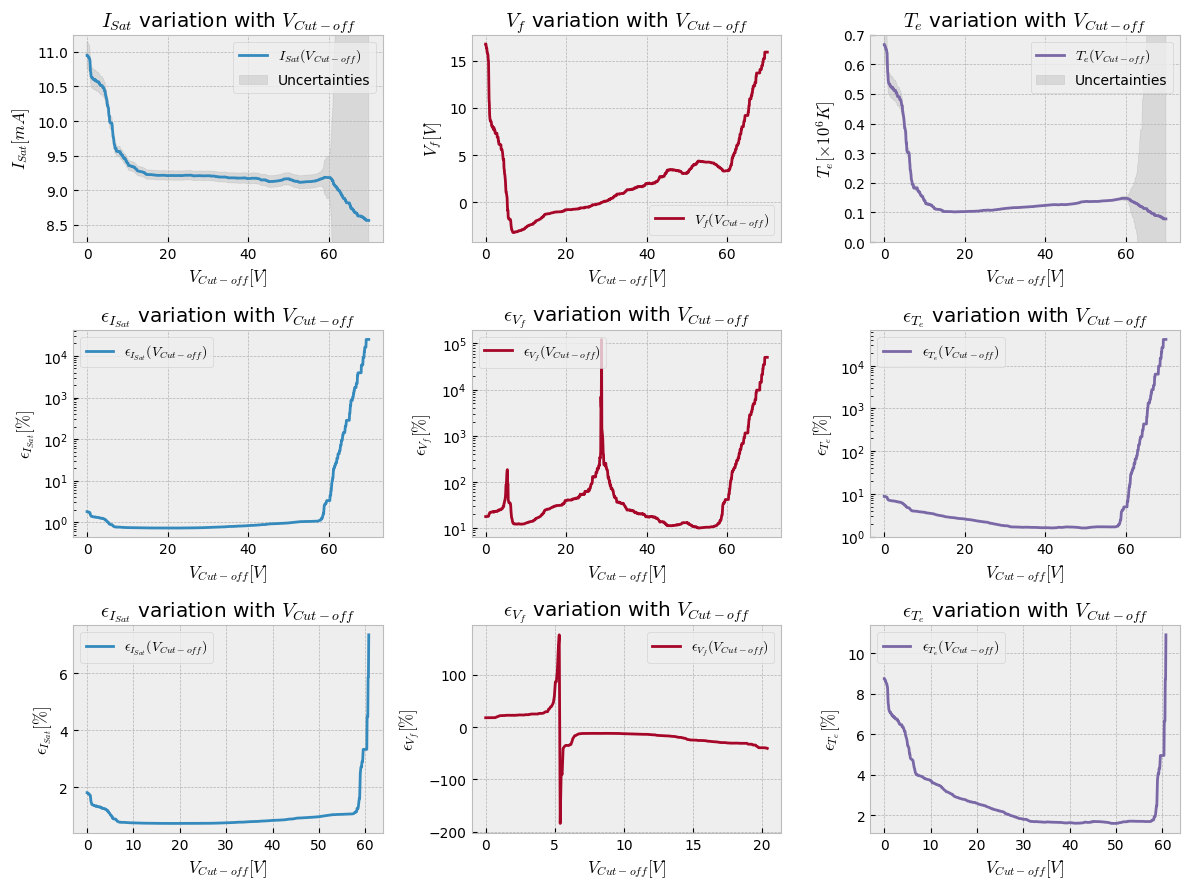

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

# For values:
axes[0,0].plot(V_Cutoff_Sweep, I_Sat_list, 'C0-', label=r'$I_{Sat}(V_{Cut-off})$')
axes[0,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0,0].set_ylabel(r'$I_{Sat} [mA]$')
axes[0,0].set_title(r'$I_{Sat}$ variation with $V_{Cut-off}$')
axes[0,0].fill_between(V_Cutoff_Sweep, np.array(I_Sat_list) - np.array(I_Sat_err_list)/100*np.array(I_Sat_list), np.array(I_Sat_list) + np.array(I_Sat_err_list)/100*np.array(I_Sat_list), color='gray', alpha=0.2, label = 'Uncertainties')
axes[0,0].set_ylim(8.25, 11.25)
axes[0,0].legend()

axes[0,1].plot(V_Cutoff_Sweep, V_f_list, 'C1-',   label=r'$V_{f}(V_{Cut-off})$')
axes[0,1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0,1].set_ylabel(r'$V_{f} [V]$')
axes[0,1].set_title(r'$V_{f}$ variation with $V_{Cut-off}$')
axes[0,1].legend()

axes[0,2].plot(V_Cutoff_Sweep, np.array(T_e_list)*1e-6, 'C2-',   label=r'$T_{e}(V_{Cut-off})$')
axes[0,2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0,2].set_ylabel(r'$T_{e} [\times 10^{6} K]$')
axes[0,2].set_title(r'$T_{e}$ variation with $V_{Cut-off}$')
axes[0,2].fill_between(V_Cutoff_Sweep, np.array(T_e_list)*1e-6 - np.array(T_e_err_list)*1e-6/100*np.array(T_e_list), np.array(T_e_list)*1e-6 + np.array(T_e_err_list)*1e-6/100*np.array(T_e_list), color='gray', alpha=0.2, label = 'Uncertainties')
axes[0,2].set_ylim(0, 0.7)  # Revisit this!
axes[0,2].legend()

# For values' uncertainties:
axes[1,0].plot(V_Cutoff_Sweep, I_Sat_err_list, 'C0-', label=r'$\epsilon_{I_{Sat}}(V_{Cut-off})$')
axes[1,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1,0].set_ylabel(r'$\epsilon_{I_{Sat}} [\%]$')
axes[1,0].set_yscale('log') # Using log scale here!
axes[1,0].set_title(r'$\epsilon_{I_{Sat}}$ variation with $V_{Cut-off}$')
axes[1,0].legend()

axes[1,1].plot(V_Cutoff_Sweep, np.abs(V_f_err_list), 'C1-',   label=r'$\epsilon_{V_{f}}(V_{Cut-off})$') # Changed this to abs()!
axes[1,1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1,1].set_ylabel(r'$\epsilon_{V_{f}} [\%]$')
axes[1,1].set_yscale('log') # Using log scale here!
axes[1,1].set_title(r'$\epsilon_{V_{f}}$ variation with $V_{Cut-off}$')
axes[1,1].legend()

axes[1,2].plot(V_Cutoff_Sweep, np.array(T_e_err_list), 'C2-',   label=r'$\epsilon_{T_{e}}(V_{Cut-off})$')
axes[1,2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1,2].set_ylabel(r'$\epsilon_{T_{e}} [\%]$')
axes[1,2].set_yscale('log') # Using log scale here!
axes[1,2].set_title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')
axes[1,2].legend()

# For values' uncertainties ('Zooming' in):
axes[2,0].plot(V_Cutoff_Sweep[:-132], I_Sat_err_list[:-132], 'C0-', label=r'$\epsilon_{I_{Sat}}(V_{Cut-off})$')
axes[2,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2,0].set_ylabel(r'$\epsilon_{I_{Sat}} [\%]$')
axes[2,0].set_title(r'$\epsilon_{I_{Sat}}$ variation with $V_{Cut-off}$')
axes[2,0].legend()

# Maybe change something here!
axes[2,1].plot(V_Cutoff_Sweep[:292], V_f_err_list[:292], 'C1-',   label=r'$\epsilon_{V_{f}}(V_{Cut-off})$') # This one doesn't consider abs()!
axes[2,1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2,1].set_ylabel(r'$\epsilon_{V_{f}} [\%]$')
axes[2,1].set_title(r'$\epsilon_{V_{f}}$ variation with $V_{Cut-off}$')
axes[2,1].legend()

axes[2,2].plot(V_Cutoff_Sweep[:-132], np.array(T_e_err_list)[:-132], 'C2-',   label=r'$\epsilon_{T_{e}}(V_{Cut-off})$')
axes[2,2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2,2].set_ylabel(r'$\epsilon_{T_{e}} [\%]$')
axes[2,2].set_title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')
axes[2,2].legend()

fig.tight_layout()
# Note that as V_f approaches 0, the relative uncertainty explodes! I shall not consider this graph to infer stuff.

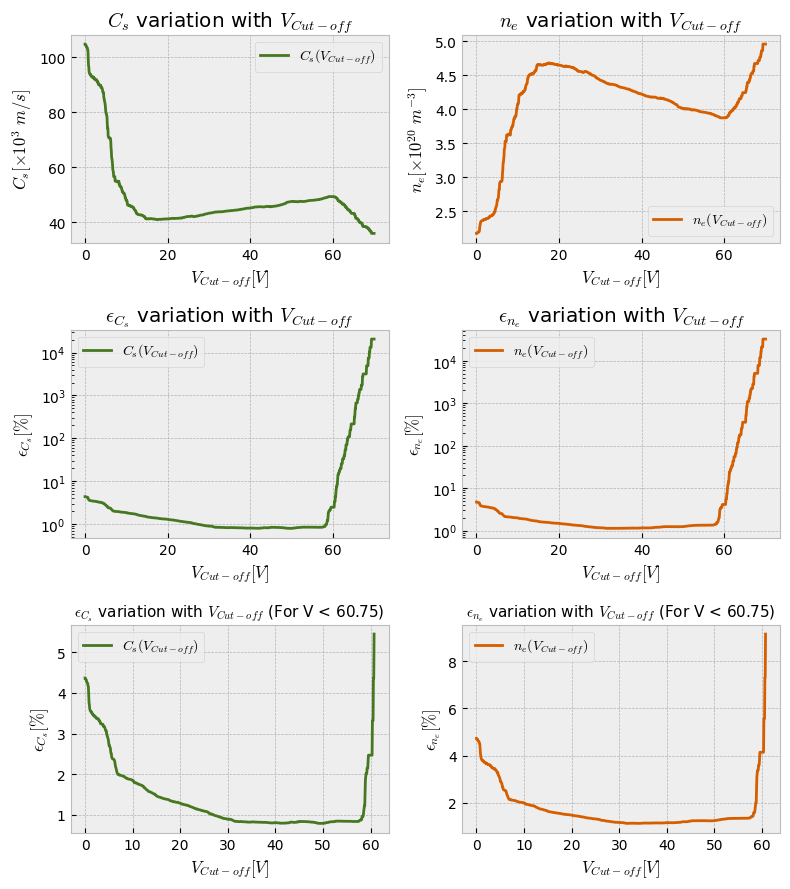

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 9))

# For values:
axes[0,0].plot(V_Cutoff_Sweep, np.array(C_s_list)*1e-3, 'C3-',   label=r'$C_{s}(V_{Cut-off})$')
axes[0,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0,0].set_ylabel(r'$C_{s} [\times 10^{3}$ $m/s]$')
axes[0,0].set_title(r'$C_{s}$ variation with $V_{Cut-off}$')
axes[0,0].legend()

axes[0,1].plot(V_Cutoff_Sweep, np.array(n_e_list)*1e-20, 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes[0,1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0,1].set_ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
axes[0,1].set_title(r'$n_{e}$ variation with $V_{Cut-off}$')
axes[0,1].legend()

# For uncertainties:
axes[1,0].plot(V_Cutoff_Sweep, np.array(C_s_err_list), 'C3-',   label=r'$C_{s}(V_{Cut-off})$')
axes[1,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1,0].set_ylabel(r'$\epsilon_{C_{s}} [\%]$')
axes[1,0].set_yscale('log') # Using log scale here!
axes[1,0].set_title(r'$\epsilon_{C_{s}}$ variation with $V_{Cut-off}$')
axes[1,0].legend()

axes[1,1].plot(V_Cutoff_Sweep, np.array(n_e_err_list), 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes[1,1].set_xlabel(r'$V_{Cut-off} [V]$') 
axes[1,1].set_ylabel(r'$\epsilon_{n_{e}} [\%]$')
axes[1,1].set_yscale('log') # Using log scale here!
axes[1,1].set_title(r'$\epsilon_{n_{e}}$ variation with $V_{Cut-off}$')
axes[1,1].legend()

# 'Zooming' in on the uncertainties:
axes[2,0].plot(V_Cutoff_Sweep[:-132], np.array(C_s_err_list)[:-132], 'C3-',   label=r'$C_{s}(V_{Cut-off})$')
axes[2,0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2,0].set_ylabel(r'$\epsilon_{C_{s}} [\%]$')
axes[2,0].set_title(r'$\epsilon_{C_{s}}$ variation with $V_{Cut-off}$' + f' (For V < {V_Cutoff_Sweep[:-132][-1]:.2f})'
, fontsize=11)
axes[2,0].legend()

axes[2,1].plot(V_Cutoff_Sweep[:-132], np.array(n_e_err_list)[:-132], 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes[2,1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2,1].set_ylabel(r'$\epsilon_{n_{e}} [\%]$')
axes[2,1].set_title(r'$\epsilon_{n_{e}}$ variation with $V_{Cut-off}$' + f' (For V < {V_Cutoff_Sweep[:-132][-1]:.2f})'
, fontsize=11)
axes[2,1].legend()

fig.tight_layout()

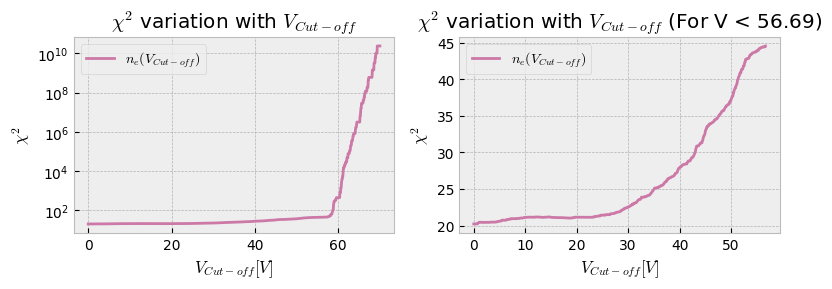

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Reduced chi squared values:
axes[0].plot(V_Cutoff_Sweep, np.array(red_chi), 'C5-',   label=r'$n_{e}(V_{Cut-off})$')
axes[0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0].set_ylabel(r'$\chi^{2}$')
axes[0].set_yscale('log') # Using log scale here!
axes[0].set_title(r'$\chi^{2}$ variation with $V_{Cut-off}$')
axes[0].legend()

axes[1].plot(V_Cutoff_Sweep[:-190], np.array(red_chi)[:-190], 'C5-',   label=r'$n_{e}(V_{Cut-off})$')
axes[1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1].set_ylabel(r'$\chi^{2}$')
axes[1].set_title(r'$\chi^{2}$ variation with $V_{Cut-off}$' + f' (For V < {V_Cutoff_Sweep[:-190][-1]:.2f})')
axes[1].legend()

fig.tight_layout()

In [ ]:
from scipy.signal import argrelextrema

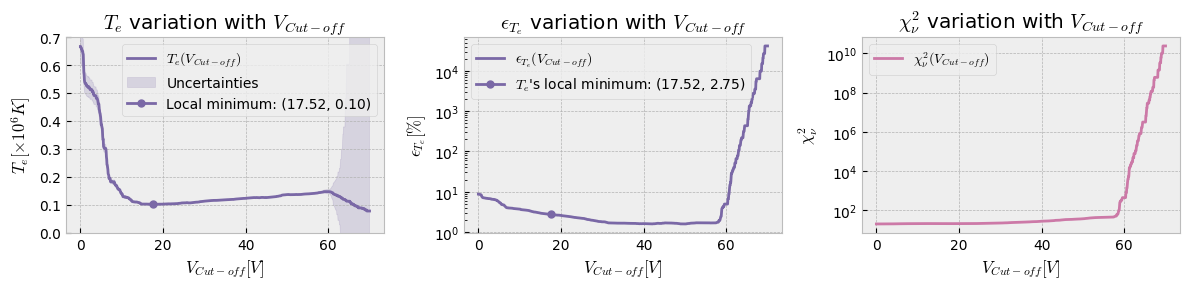

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# T_e values:
axes[0].plot(V_Cutoff_Sweep, np.array(T_e_list)*1e-6, 'C2-',   label=r'$T_{e}(V_{Cut-off})$')
axes[0].set_xlabel(r'$V_{Cut-off} [V]$')
axes[0].set_ylabel(r'$T_{e} [\times 10^{6} K]$')
axes[0].set_title(r'$T_{e}$ variation with $V_{Cut-off}$')
axes[0].fill_between(V_Cutoff_Sweep, np.array(T_e_list)*1e-6 - np.array(T_e_err_list)*1e-6/100*np.array(T_e_list), np.array(T_e_list)*1e-6 + np.array(T_e_err_list)*1e-6/100*np.array(T_e_list), color='C2', alpha=0.2, label = 'Uncertainties')
Ind = argrelextrema(np.array(T_e_list)*1e-6, np.less)[0][22] # [22] was checked manually...

# Debugging:
# print(Ind, V_Cutoff_Sweep[Ind], T_e_list[Ind]*1e-6)
# print(np.array(T_e_list)[argrelextrema(np.array(T_e_list)*1e-6, np.less)[0]]*1e-6)

axes[0].plot(V_Cutoff_Sweep[Ind], T_e_list[Ind]*1e-6, marker = 'o', markersize = 5, color = 'C2',
label = f'Local minimum: ({V_Cutoff_Sweep[Ind]:.2f}, {T_e_list[Ind]*1e-6:.2f})')
axes[0].set_ylim(0, 0.7)  # Revisit this!
axes[0].legend()

# T_e uncertainties:
axes[1].plot(V_Cutoff_Sweep, np.array(T_e_err_list), 'C2-',   label=r'$\epsilon_{T_{e}}(V_{Cut-off})$')
axes[1].set_xlabel(r'$V_{Cut-off} [V]$')
axes[1].set_ylabel(r'$\epsilon_{T_{e}} [\%]$')
axes[1].set_yscale('log') # Using log scale here!
axes[1].set_title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')

axes[1].plot(V_Cutoff_Sweep[Ind], T_e_err_list[Ind], marker = 'o', markersize = 5, color = 'C2',
label = r'$T_{e}$' + f'\'s local minimum: ({V_Cutoff_Sweep[Ind]:.2f}, {T_e_err_list[Ind]:.2f})')

axes[1].legend()

# Reduced chi squared values:
axes[2].plot(V_Cutoff_Sweep, np.array(red_chi), 'C5-',   label=r'$\chi^{2}_{\nu}(V_{Cut-off})$')
axes[2].set_xlabel(r'$V_{Cut-off} [V]$')
axes[2].set_ylabel(r'$\chi^{2}_{\nu}$')
axes[2].set_yscale('log') # Using log scale here!
axes[2].set_title(r'$\chi^{2}_{\nu}$ variation with $V_{Cut-off}$')
axes[2].legend()

fig.tight_layout()

plt.savefig('1_Params(V_Cutt-off).svg', format = 'svg')

## **$2^{nd}$ Part:**

Temporal evolution of the plasma parameters along one plasma cycle, ~25 ms (data in
**Table 2**, although data in table 1 may also be used). 

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35604|CHANNEL_030|CHANNEL_026|
|35605|CHANNEL_029|CHANNEL_026|
|36891|CHANNEL_028|CHANNEL_029|
|36891|CHANNEL_026|CHANNEL_029|

**Table 2:** Data for the temporal evolution analysis.

</center>

In [ ]:
# Load and select data
shot = 35604
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

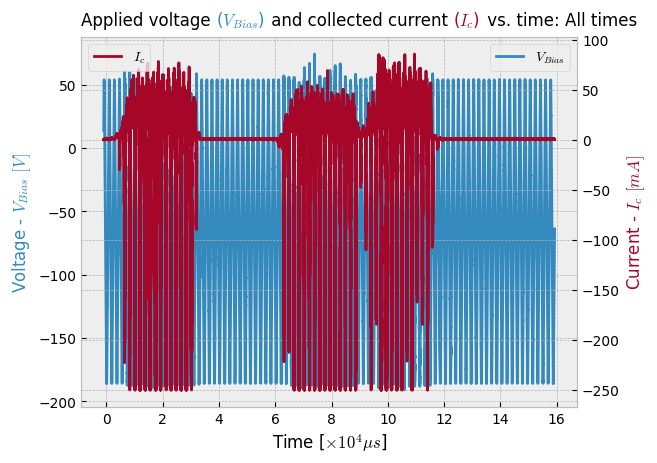

<Figure size 640x480 with 0 Axes>

In [ ]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
# plt.savefig('TestFig1.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets...
# Here, the 3 cycles are visible.

In [ ]:
# Selecting a time interval:
bool_indices = (time > 3500) & (time < 33500.5) # Considering only the 1st cycle (~30 ms)
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]
print(time_d[0], time_d[-1], time_d[-1]-time_d[0])

3500.5 33500.0 29999.5


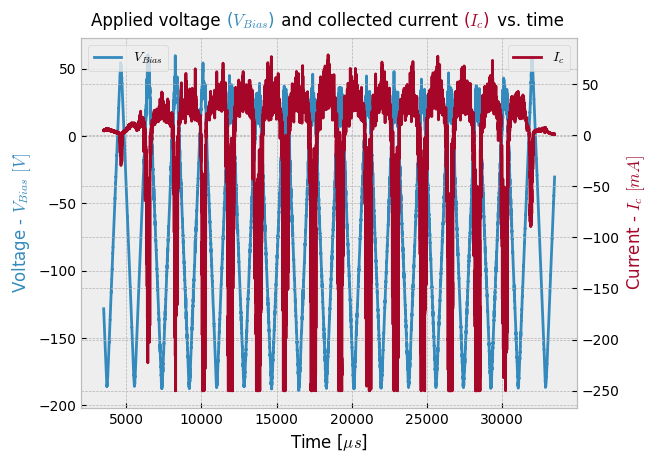

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend()
plt.savefig('2_1st_Cycle.svg', format = 'svg')
plt.show()
plt.clf()
# plt.close() # Useful when dealing with widgets instead...

In [ ]:
# Splitting np.array in 16 chunks, since we seem to have roughly 16 I-V characteristic curves.
print(len(V_data_d)) # Debugging: {split_j} must be a divisor of {len(V_data_d)} for 'split' to work!
split_j = 16
V_d = np.split(V_data_d, split_j)
I_d = np.split(I_data_d, split_j)
t_d = np.split(time_d, split_j)

60000


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

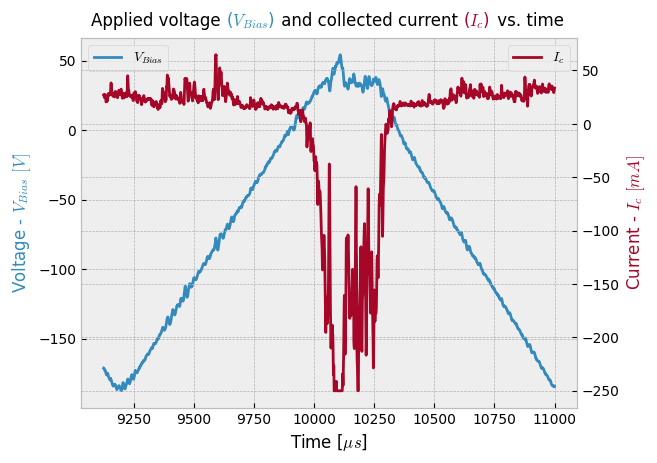

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

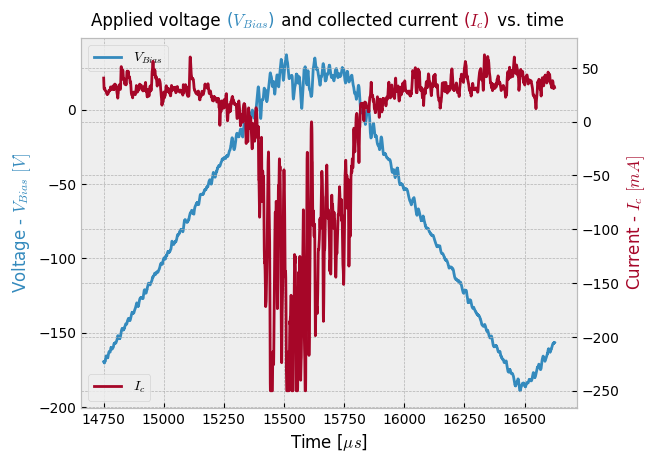

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

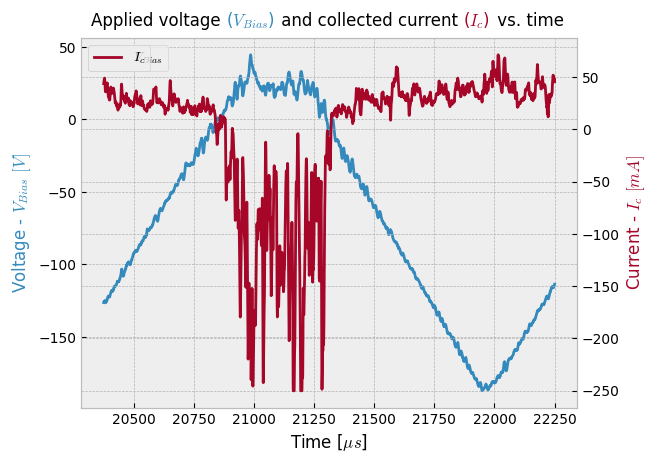

<Figure size 640x480 with 0 Axes>

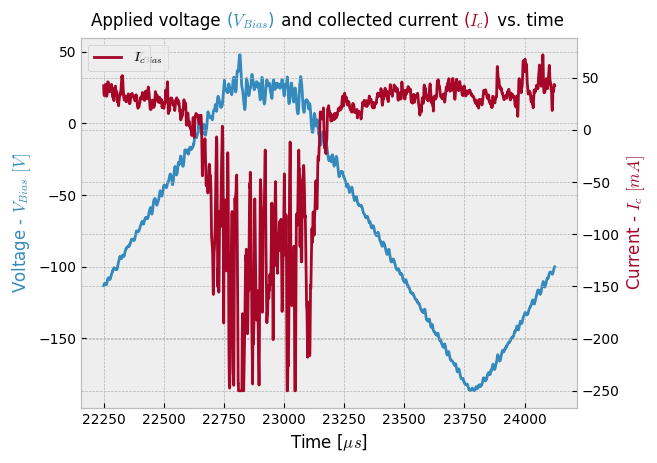

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

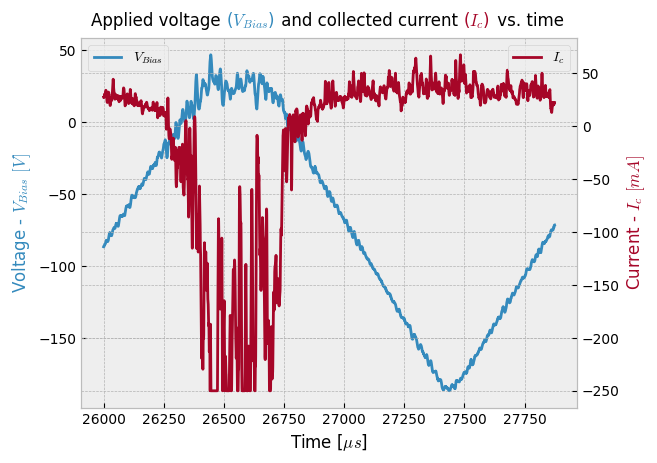

<Figure size 640x480 with 0 Axes>

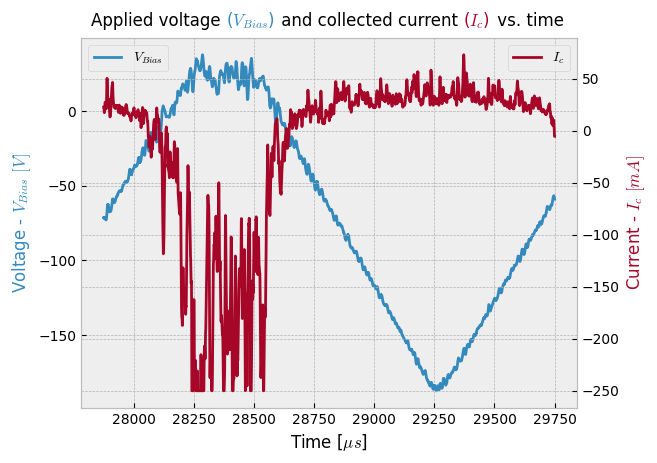

<Figure size 640x480 with 0 Axes>

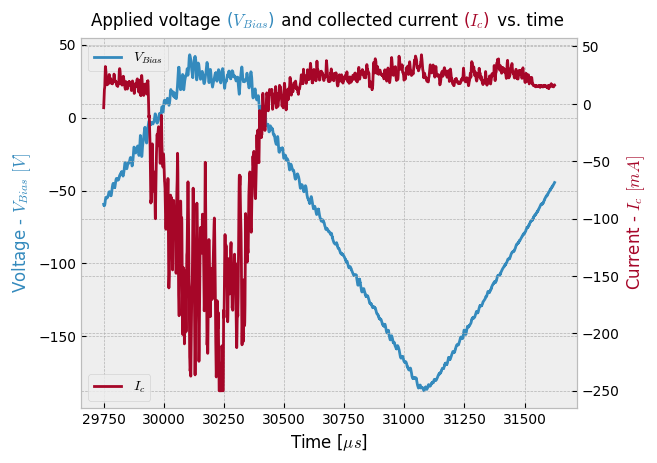

<Figure size 640x480 with 0 Axes>

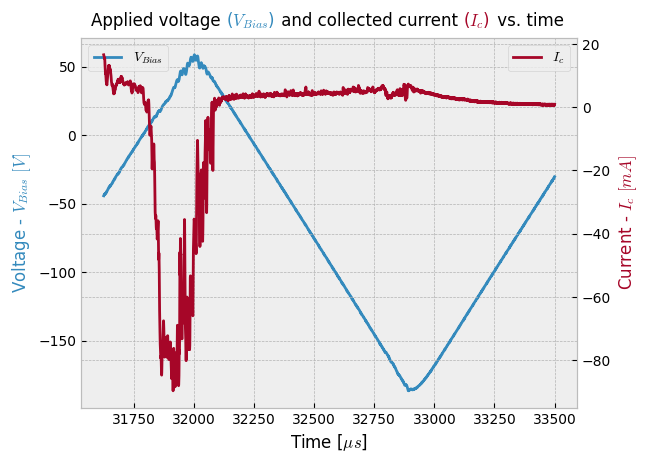

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the selected time interval:
for i in range(0, split_j):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(t_d[i], V_d[i], 'C0-', label=r'$V_{Bias}$')
    ax2.plot(t_d[i], I_d[i], 'C1-', label=r'$I_c$')

    ax1.set_xlabel(r'Time [$\mu s$]')
    ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
    ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

    label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
    colors = ['black', 'C0', 'black', 'C1', 'black']
    color_title(label_list, colors)

    plt.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend()
    # plt.savefig('TestFig1.svg', format = 'svg')
    plt.show()
    plt.clf()
    # plt.close() # Useful when dealing with widgets instead...

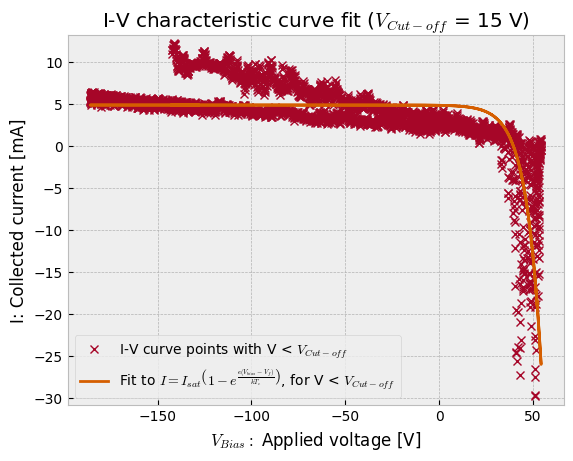

I_Sat = 4.84+/-0.06 [mA]
V_f = 39.5+/-0.4 [V]
T_e = (9.3+/-0.4)e+04 [K]
C_s = (3.92+/-0.08)e+04 [m/s]
n_e = (2.57+/-0.06)e+20 [m**(-3)]
V_p = 63.5+/-1.1 [V]
Reduce chi squared = 11.142535547114473. Should be ~1.


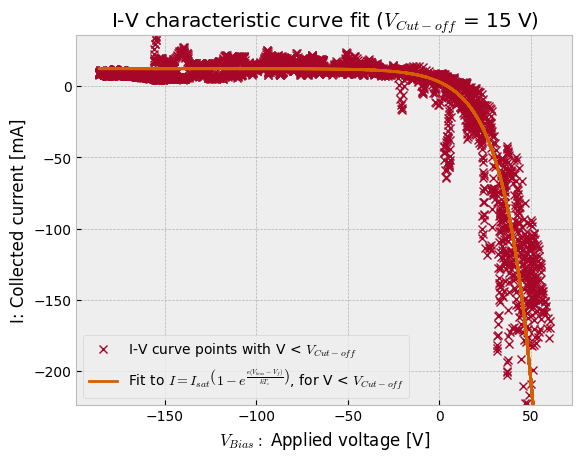

I_Sat = 12.40+/-0.12 [mA]
V_f = 4.5+/-0.4 [V]
T_e = (1.833+/-0.027)e+05 [K]
C_s = (5.50+/-0.04)e+04 [m/s]
n_e = (4.69+/-0.06)e+20 [m**(-3)]
V_p = 51.9+/-0.8 [V]
Reduce chi squared = 34.233527694796095. Should be ~1.


I_Sat = 21.83+/-0.13 [mA]
V_f = 11.51+/-0.34 [V]
T_e = (1.712+/-0.028)e+05 [K]
C_s = (5.32+/-0.04)e+04 [m/s]
n_e = (8.54+/-0.09)e+20 [m**(-3)]
V_p = 55.8+/-0.8 [V]
Reduce chi squared = 40.16581463904571. Should be ~1.


I_Sat = 25.59+/-0.12 [mA]
V_f = 12.21+/-0.31 [V]
T_e = (1.489+/-0.022)e+05 [K]
C_s = (4.96+/-0.04)e+04 [m/s]
n_e = (1.074+/-0.010)e+21 [m**(-3)]
V_p = 50.7+/-0.7 [V]
Reduce chi squared = 36.93941623083144. Should be ~1.


I_Sat = 35.28+/-0.19 [mA]
V_f = -5.46+/-0.35 [V]
T_e = (1.949+/-0.032)e+05 [K]
C_s = (5.67+/-0.05)e+04 [m/s]
n_e = (1.294+/-0.013)e+21 [m**(-3)]
V_p = 44.9+/-0.9 [V]
Reduce chi squared = 72.04246599866754. Should be ~1.


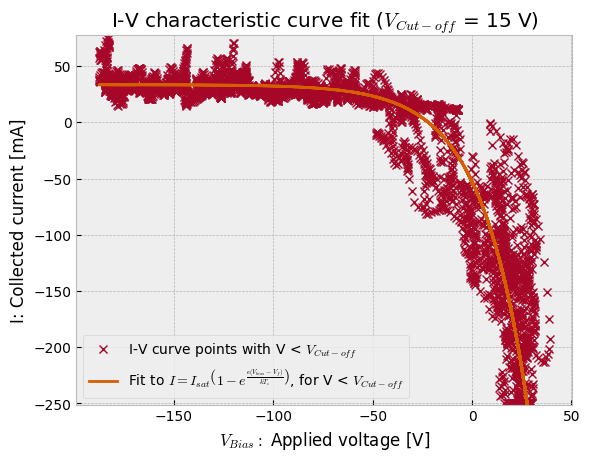

I_Sat = 33.40+/-0.25 [mA]
V_f = -22.1+/-0.5 [V]
T_e = (2.70+/-0.04)e+05 [K]
C_s = (6.68+/-0.05)e+04 [m/s]
n_e = (1.040+/-0.011)e+21 [m**(-3)]
V_p = 47.8+/-1.2 [V]
Reduce chi squared = 98.69673055672017. Should be ~1.


I_Sat = 33.77+/-0.18 [mA]
V_f = -4.63+/-0.34 [V]
T_e = (1.989+/-0.032)e+05 [K]
C_s = (5.73+/-0.05)e+04 [m/s]
n_e = (1.226+/-0.012)e+21 [m**(-3)]
V_p = 46.8+/-0.9 [V]
Reduce chi squared = 69.26723142485943. Should be ~1.


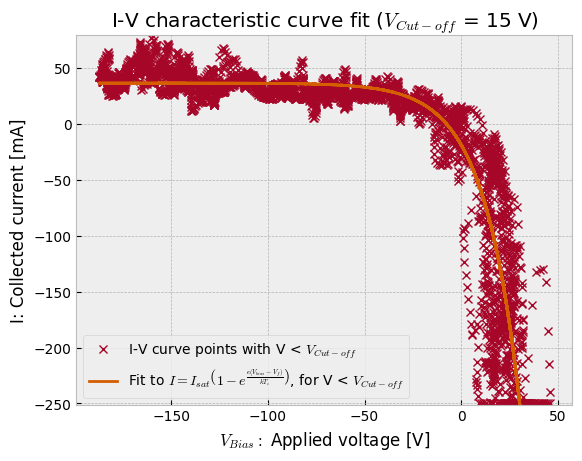

I_Sat = 36.36+/-0.21 [mA]
V_f = -7.7+/-0.4 [V]
T_e = (2.132+/-0.035)e+05 [K]
C_s = (5.93+/-0.05)e+04 [m/s]
n_e = (1.275+/-0.013)e+21 [m**(-3)]
V_p = 47.5+/-1.0 [V]
Reduce chi squared = 89.32566187406438. Should be ~1.


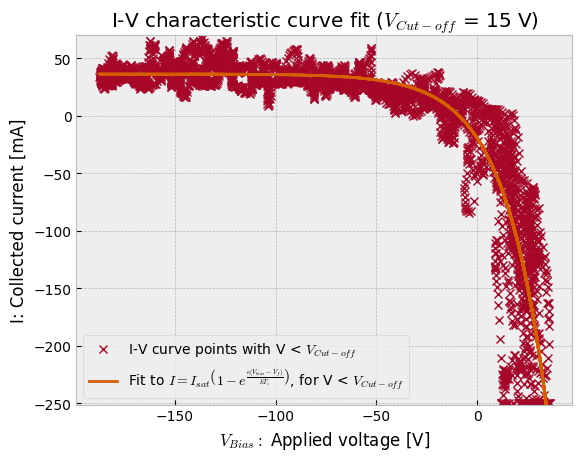

I_Sat = 36.39+/-0.22 [mA]
V_f = -8.9+/-0.4 [V]
T_e = (2.43+/-0.04)e+05 [K]
C_s = (6.33+/-0.05)e+04 [m/s]
n_e = (1.196+/-0.012)e+21 [m**(-3)]
V_p = 53.8+/-1.0 [V]
Reduce chi squared = 88.71743172142142. Should be ~1.


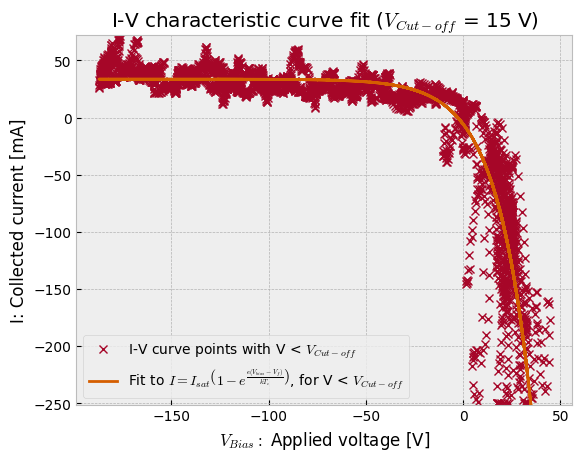

I_Sat = 33.61+/-0.19 [mA]
V_f = -2.8+/-0.4 [V]
T_e = (2.040+/-0.035)e+05 [K]
C_s = (5.80+/-0.05)e+04 [m/s]
n_e = (1.205+/-0.013)e+21 [m**(-3)]
V_p = 50.0+/-1.0 [V]
Reduce chi squared = 77.08011903199647. Should be ~1.


I_Sat = 34.46+/-0.19 [mA]
V_f = -9.8+/-0.4 [V]
T_e = (2.362+/-0.034)e+05 [K]
C_s = (6.25+/-0.05)e+04 [m/s]
n_e = (1.148+/-0.011)e+21 [m**(-3)]
V_p = 51.3+/-1.0 [V]
Reduce chi squared = 70.26702451680633. Should be ~1.


I_Sat = 37.32+/-0.25 [mA]
V_f = -13.6+/-0.4 [V]
T_e = (3.17+/-0.05)e+05 [K]
C_s = (7.24+/-0.05)e+04 [m/s]
n_e = (1.073+/-0.011)e+21 [m**(-3)]
V_p = 68.4+/-1.3 [V]
Reduce chi squared = 92.20080622433937. Should be ~1.


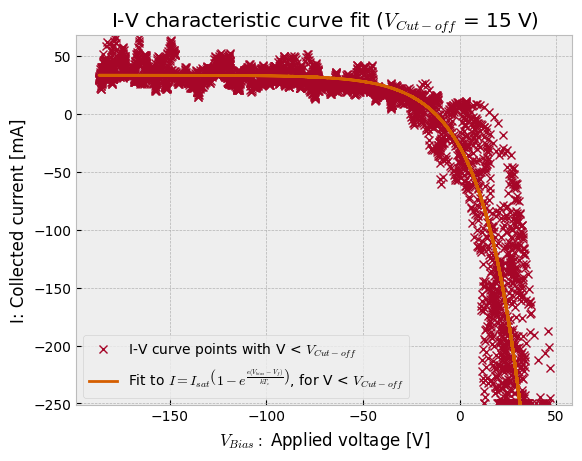

I_Sat = 33.68+/-0.19 [mA]
V_f = -12.33+/-0.34 [V]
T_e = (2.376+/-0.030)e+05 [K]
C_s = (6.26+/-0.04)e+04 [m/s]
n_e = (1.119+/-0.009)e+21 [m**(-3)]
V_p = 49.1+/-0.8 [V]
Reduce chi squared = 64.4429720425054. Should be ~1.


I_Sat = 31.25+/-0.19 [mA]
V_f = -17.34+/-0.35 [V]
T_e = (2.555+/-0.030)e+05 [K]
C_s = (6.49+/-0.04)e+04 [m/s]
n_e = (1.001+/-0.009)e+21 [m**(-3)]
V_p = 48.7+/-0.9 [V]
Reduce chi squared = 62.42805061398897. Should be ~1.


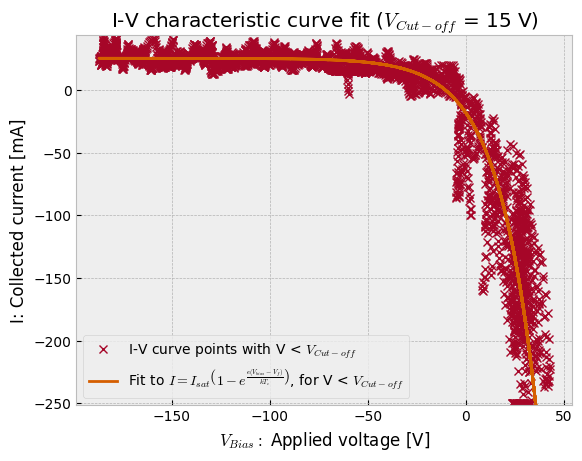

I_Sat = 25.13+/-0.14 [mA]
V_f = -10.47+/-0.32 [V]
T_e = (2.239+/-0.025)e+05 [K]
C_s = (6.080+/-0.034)e+04 [m/s]
n_e = (8.60+/-0.07)e+20 [m**(-3)]
V_p = 47.4+/-0.7 [V]
Reduce chi squared = 36.98367127550211. Should be ~1.


I_Sat = 3.9+/-2.9 [mA]
V_f = 28+/-15 [V]
T_e = (5+/-6)e+04 [K]
C_s = (2.7+/-1.9)e+04 [m/s]
n_e = (3.0+/-3.0)e+20 [m**(-3)]
V_p = 40+/-22 [V]
Reduce chi squared = 26231.1136954183. Should be ~1.


<Figure size 640x480 with 0 Axes>

In [ ]:
T_e_Time = []
T_e_Time_Epsilon = []
n_e_Time = []
n_e_Time_Epsilon = []
V_f_Time = []
V_f_Time_Epsilon = []
V_p_Time = []
C_s_Time = []
Red_Chi_Time = []

for j in range(0, split_j):
    # Note that cut-off voltage was not considered for this analysis!
    # It should, but this would just make things more complicated. Results are fine this way...

    # Defining fitting function and fitting:
    def func(B, V_Bias): # T_ef = T_e*(k/e)
        return B[0] * (1 - np.exp((V_Bias - B[1])/(B[2])))
    
    Fit_Model = Model(func)
    My_Data = RealData(V_d[j], I_d[j])
    odr = ODR(My_Data, Fit_Model, beta0=[10, -1, 2e5*(k/e)]) # Was [1., 0., 1.] before!
    out = odr.run()
    
    # Retrieving parameters and their standard deviations:
    parameters = out.beta
    perr = out.sd_beta

    plt.plot(V_d[j], I_d[j], 'x',
    label=r'I-V curve points with V < $V_{Cut-off}$',
    color = 'C1')
    plt.plot(V_d[j], func(out.beta, V_d[j]),
    label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
    color = 'C4')

    plt.ylim([min(I_d[j]) - 1, max(I_d[j]) + 1])

    plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
    plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
    plt.ylabel(r'I: Collected current [mA]')
    plt.grid(True)
    plt.legend(loc = 'best')
    # plt.savefig('TestFig1.svg', format = 'svg')
    plt.show()
    plt.clf()
    # plt.close() # Useful when dealing with widgets instead...

    # Retrieving parameters and their standard deviations:
    parameters = out.beta
    perr = out.sd_beta

    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    T_e_ufloat = ufloat(parameters[2], perr[2])
    T_e_ufloat*=(e/k)

    I_Sat_ufloat = ufloat(parameters[0], perr[0])
    V_f_ufloat = ufloat(parameters[1], perr[1])

    C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
    n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
    V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e

    red_chi_sq = out.res_var

    T_e_Time.append(T_e_ufloat.n)
    T_e_Time_Epsilon.append(T_e_ufloat.s)

    n_e_Time.append(n_e_ufloat.n)
    n_e_Time_Epsilon.append(n_e_ufloat.s)

    V_f_Time.append(V_f_ufloat.n)
    V_f_Time_Epsilon.append(V_f_ufloat.s)

    V_p_Time.append(V_p_ufloat)

    C_s_Time.append(C_s_ufloat)
    
    Red_Chi_Time.append(red_chi_sq)
    
    # Printing results
    print(f'I_Sat = {I_Sat_ufloat} [mA]')
    print(f'V_f = {V_f_ufloat} [V]')
    print(f'T_e = {T_e_ufloat} [K]')

    print(f'C_s = {C_s_ufloat} [m/s]')
    print(f'n_e = {n_e_ufloat} [m**(-3)]')
    print(f'V_p = {V_p_ufloat} [V]')

    print(f'Reduce chi squared = {red_chi_sq}. Should be ~1.')

In [ ]:
labels = []
delta = t_d[0][-1] - t_d[0][0]
for i in range(0, split_j):
    labels.append(f'[{(t_d[0][0] + delta*i + 0.5*i)/1000:.2f}, {(t_d[0][0] + delta*(i+1) + 0.5*i)/1000:.2f}]')

print(f'Labels = {labels}') # Debugging!

Labels = ['[3.50, 5.38]', '[5.38, 7.25]', '[7.25, 9.12]', '[9.13, 11.00]', '[11.00, 12.88]', '[12.88, 14.75]', '[14.75, 16.62]', '[16.63, 18.50]', '[18.50, 20.38]', '[20.38, 22.25]', '[22.25, 24.12]', '[24.13, 26.00]', '[26.00, 27.88]', '[27.88, 29.75]', '[29.75, 31.62]', '[31.63, 33.50]']


In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(dict(data=np.array(n_e_Time)/1e20))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C4', ms=10, label = r'$n_{e}$ Line')
df['data'].plot(kind='bar', color='C1', alpha = 0.95, width = 0.95, label = r'$n_{e}$',
yerr=[val/1e20 for val in n_e_Time_Epsilon], capsize=3)
plt.title(r'$n_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
plt.legend()
plt.savefig('2_n_e(t).svg', format = 'svg')
plt.show()

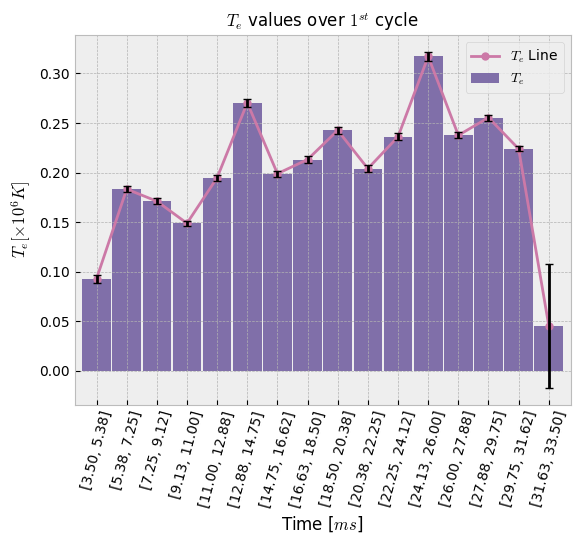

In [ ]:
df = pd.DataFrame(dict(data=np.array(T_e_Time)/1e6))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C5', ms=10, label = r'$T_{e}$ Line')
df['data'].plot(kind='bar', color='C2', alpha = 0.95, width = 0.95, label = r'$T_{e}$',
yerr=np.array(T_e_Time_Epsilon)/1e6, capsize=3)
plt.title(r'$T_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$T_{e} [\times 10^{6} K]$')
plt.legend()
plt.savefig('2_T_e(t).svg', format = 'svg')
plt.show()

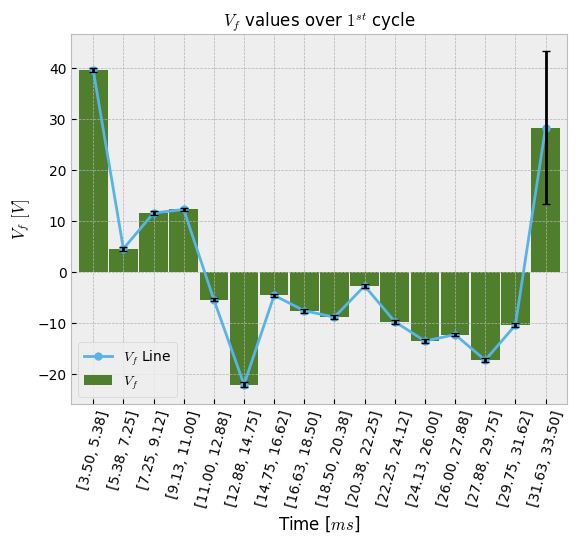

In [ ]:
df = pd.DataFrame(dict(data=np.array(V_f_Time)))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C6', ms=10, label = r'$V_{f}$ Line')
df['data'].plot(kind='bar', color='C3', alpha = 0.95, width = 0.95, label = r'$V_{f}$',
yerr=np.array(V_f_Time_Epsilon), capsize=3)
plt.title(r'$V_{f}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{f}$ $[V]$')
plt.legend()
plt.show()

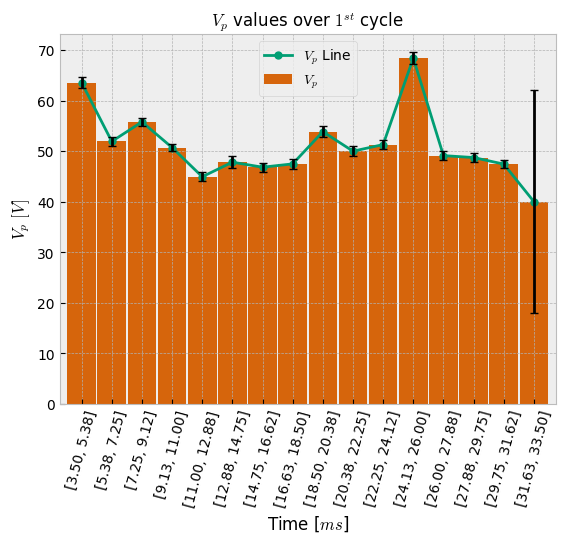

In [ ]:
df = pd.DataFrame(dict(data=np.array([val.n for val in V_p_Time])))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C7', ms=10, label = r'$V_{p}$ Line')
df['data'].plot(kind='bar', color='C4', alpha = 0.95, width = 0.95, label = r'$V_{p}$',
yerr=[val.s for val in V_p_Time], capsize=3)
plt.title(r'$V_{p}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{p}$ $[V]$')
plt.legend()
plt.show()

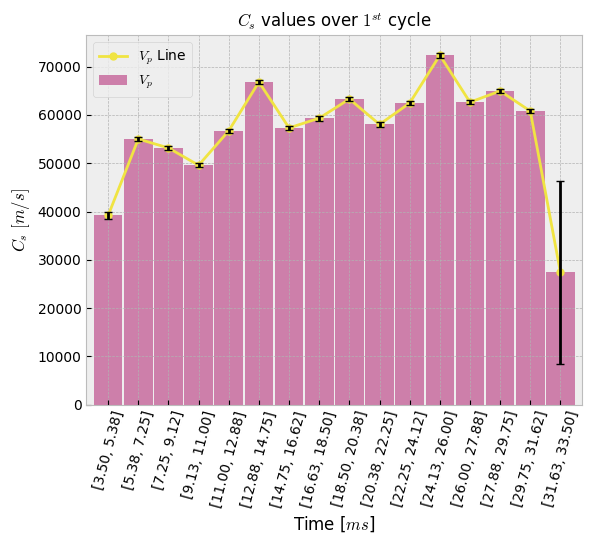

In [ ]:
df = pd.DataFrame(dict(data=np.array([val.n for val in C_s_Time])))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C8', ms=10, label = r'$V_{p}$ Line')
df['data'].plot(kind='bar', color='C5', alpha = 0.95, width = 0.95, label = r'$V_{p}$',
yerr=[val.s for val in C_s_Time], capsize=3)
plt.title(r'$C_{s}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$C_{s}$ $[m/s]$')
plt.legend()
plt.show()

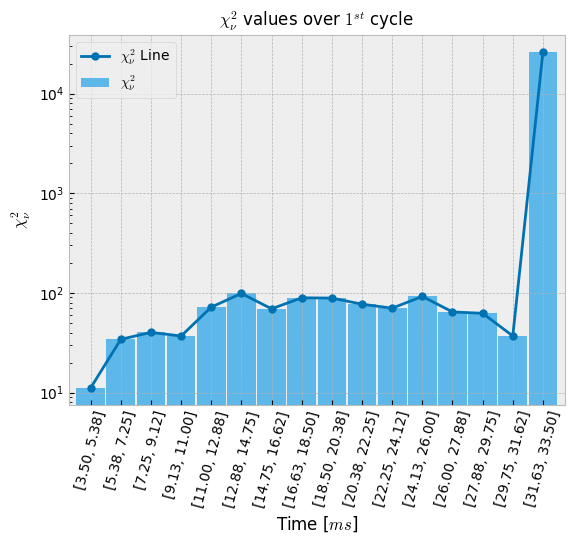

In [ ]:
df = pd.DataFrame(dict(data=np.array(Red_Chi_Time)))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C9', ms=10, label = r'$\chi^{2}_{\nu}$ Line')
df['data'].plot(kind='bar', color='C6', alpha = 0.95, width = 0.95, label = r'$\chi^{2}_{\nu}$', capsize=3)
plt.title(r'$\chi^{2}_{\nu}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$\chi^{2}_{\nu}$')
plt.yscale("log") # Explore this option better!
plt.legend()
plt.savefig('2_Red_Chi(t).svg', format = 'svg')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# n_e values:
axes.plot(V_Cutoff_Sweep, np.array(n_e_list)*1e-20, 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes.fill_between(V_Cutoff_Sweep, np.array(n_e_list)*1e-20 - np.array(n_e_err_list)*1e-20/100*np.array(n_e_list), np.array(n_e_list)*1e-20 + np.array(n_e_err_list)*1e-20/100*np.array(n_e_list), color='C4', alpha=0.2, label = 'Uncertainties')
axes.set_xlabel(r'$V_{Cut-off} [V]$')
axes.set_ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
axes.set_ylim(1.95, 5.15)
axes.set_title(r'$n_{e}$ variation with $V_{Cut-off}$')

# Debugging:
Ind = argrelextrema(np.array(n_e_list)*1e-20, np.greater)[0][21] # [21] was checked manually...
# print(Ind, V_Cutoff_Sweep[Ind], n_e_list[Ind]*1e-20)
# print(np.array(n_e_list)[argrelextrema(np.array(n_e_list)*1e-20, np.greater)[0]]*1e-20)

axes.plot(V_Cutoff_Sweep[Ind], n_e_list[Ind]*1e-20, marker = 'o', markersize = 5, color = 'C4',
label = f'Local maximum: ({V_Cutoff_Sweep[Ind]:.2f}, {n_e_list[Ind]*1e-20:.2f})')
axes.legend()

fig.tight_layout()

plt.savefig('1_n_e(V_Cutt-off).svg', format = 'svg')

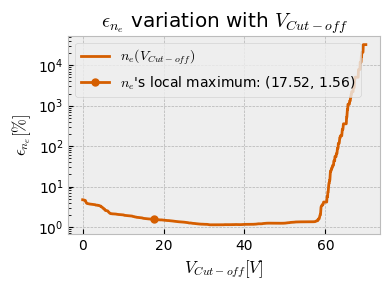

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))

# n_e uncertainties:
axes.plot(V_Cutoff_Sweep, np.array(n_e_err_list), 'C4-',   label=r'$n_{e}(V_{Cut-off})$')
axes.set_xlabel(r'$V_{Cut-off} [V]$') 
axes.set_ylabel(r'$\epsilon_{n_{e}} [\%]$')
axes.set_yscale('log') # Using log scale here!
axes.set_title(r'$\epsilon_{n_{e}}$ variation with $V_{Cut-off}$')
axes.legend()

axes.plot(V_Cutoff_Sweep[Ind], n_e_err_list[Ind], marker = 'o', markersize = 5, color = 'C4',
label = r'$n_{e}$' + f'\'s local maximum: ({V_Cutoff_Sweep[Ind]:.2f}, {n_e_err_list[Ind]:.2f})')

axes.legend()

fig.tight_layout()

plt.savefig('1_Eps_n_e(V_Cutt-off).svg', format = 'svg')